## Introduction
Incorporate transaction cost into the portfolio optimization process.Use one factor model to get a reliable covariance matrix during the process.Model transaction fixed cost as a linear function of allocation change and variable cost(market impact) as a quadratic function of allocation change.Use cvxpy library to solve the optimized portfolio weight.

### 1. Get data from Yahoo Finance

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxpy as cp

In [588]:
from datetime import datetime, timedelta

# List of 12 stock tickers
stock_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META','TSLA', 'JPM', 'V', 'PYPL', 'NVDA','BA','GS','^GSPC']

# Calculate start and end dates for the last 12 months
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

# Dictionary to store close price data for each ticker
close_prices = {}

# Download close price data for each ticker
for ticker in stock_tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        # Resample to get month-end close prices
        monthly_close = stock_data['Close'].resample('M').last()
        close_prices[ticker] = monthly_close
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Create a DataFrame from the collected data
df = pd.DataFrame(close_prices)
df.to_csv('12stocks&sp.csv', index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

DataFrame with Monthly Close Prices:


### 2.Read Data and Calculate Returns

<AxesSubplot:xlabel='Date'>

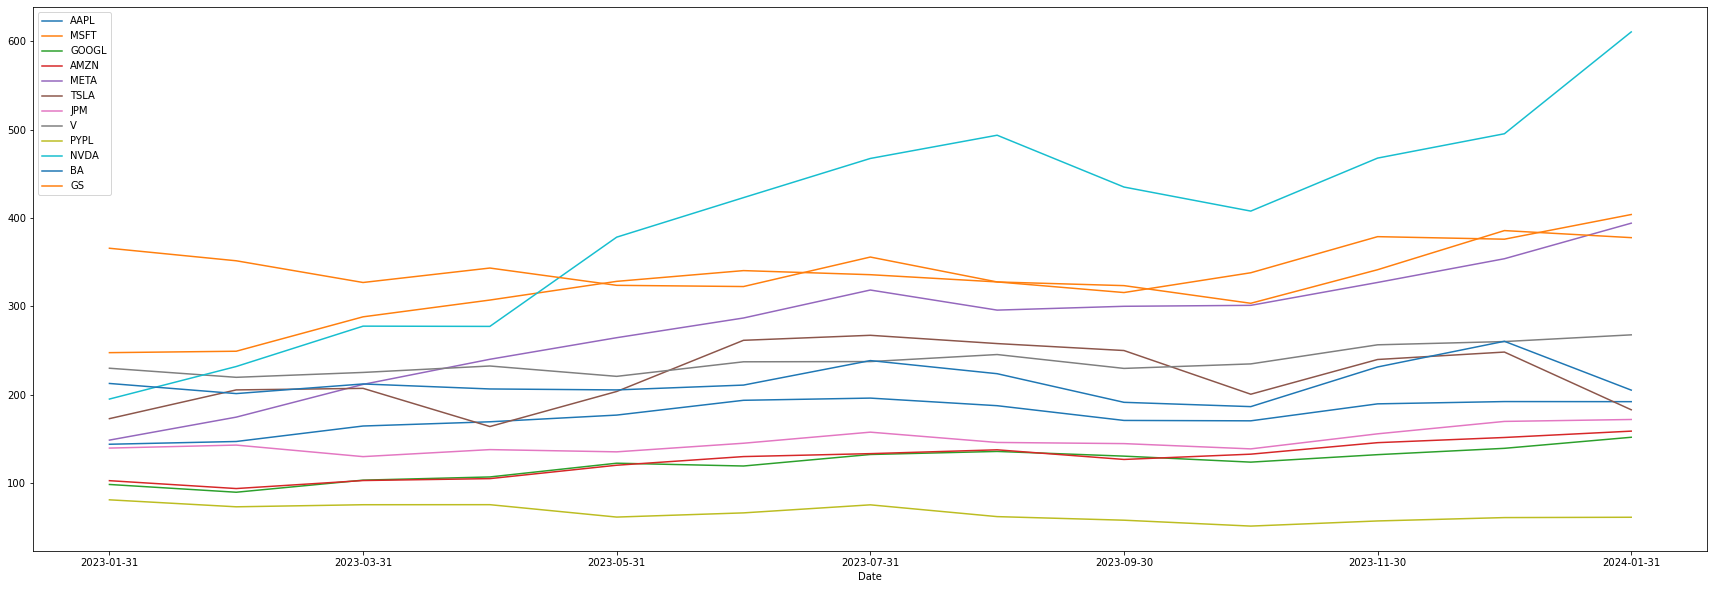

In [9]:
# read data directly
df = pd.read_csv('12stocks&sp.csv',index_col=0)
df.iloc[:,0:12].plot(figsize=(30,10))

In [10]:
def cal_returns(data):
    monthly_returns = data.pct_change().dropna()
    monthly_returns.index = pd.to_datetime(monthly_returns.index).strftime('%Y-%m')
    return monthly_returns
monthly_returns = cal_returns(df)
col_n = monthly_returns.shape[1]-1

### 3. Covariance Matrix

In [11]:
def traditional_cov(data):
    excess_returns = data.iloc[:,0:col_n].sub(data.iloc[:,0:col_n].mean(axis=0), axis=1)
    matrix_data = excess_returns.values
    transpose_matrix = np.transpose(matrix_data)
    cov_matrix = np.matmul(transpose_matrix, matrix_data)/(col_n-1) # n is periods T. Here, T=col_n
    return cov_matrix

traditional_cov = traditional_cov(monthly_returns)

In [13]:
def is_sigular(matrix,tolerance=1e-40):
    determinant = np.linalg.det(matrix)
    is_singular = abs(determinant) < tolerance
    return is_singular

is_singular = is_sigular(traditional_cov,tolerance=1e-40)
print("Is the covariance matrix singular?", is_singular)

Is the covariance matrix singular? True


The traditional covariance matrix is singular under the tolerance 1e-40.When the number of stocks in the portfolio is greater than or equal to the number of observations used in the estimation, the traditional sample covariance
becomes singular.
To avoid the singularity of the sample covariance and to obtain a reliable and stable estimate of the covariance matrix, use a single factor model to estimate the covanriance matrix:

In [25]:
def para_fatorModel(data):
    betas = []
    std_residual = []
    x = data['^GSPC']
    variance_m = np.var(data['^GSPC'], ddof=1)

    for i in range(col_n):
        y = data.iloc[:,i]
        slope, intercept = np.polyfit(x, y, 1)
        residuals = y - (slope * x + intercept)
        steyx = np.std(residuals, ddof=1)

        betas.append(slope)
        std_residual.append(steyx)
        

    betas = np.array(betas).reshape(1,col_n)
    std_residual = np.array(std_residual).reshape(1,col_n)
    
    return betas, std_residual, variance_m

betas, std_residual, variance_m = para_fatorModel(monthly_returns)

In [28]:
def cov_factor(beta,std_residual,variance_m):
    transpose_betas = np.transpose(beta)
    transpose_std_residual = np.transpose(std_residual)
    b_t_b = np.matmul(transpose_betas,beta)
    theta_t_theta = np.matmul(transpose_std_residual,std_residual)
    diag = np.eye(col_n)
    diag_theta = theta_t_theta*diag
    cov_matrix2 = b_t_b*variance_m + diag_theta
    return cov_matrix2

cov_factor = cov_factor(betas, std_residual, variance_m)

In [29]:
is_singular = is_sigular(cov_factor,tolerance=1e-40)
print("Is the covariance matrix singular?", is_singular)

Is the covariance matrix singular? False


### 4. Model Fixed Cost in Linear Form - Solved with cvxpy
Broadly speaking, there are two kinds of transaction costs: fixed costs and variable costs. The fixed costs are related to trade commissions and bid/ask spreads.They are both a linear function of the traded amount or the number of trade tickets.Below I model these cost in linear form with W = W_0 + W_B + W_S, where W_0 is the initial allocation, W_B is the "buy how much" weight vector and W_S is the "sell how much" weight vector. Stack W_B and W_S vertically to form the weight vector in the problem.

In [30]:
# Linear cost coefficient:theta
np.random.seed(2)
lower_bound = 0.001
upper_bound = 0.02
array_12x1 = np.random.uniform(lower_bound, upper_bound, size=(12, 1))
theta = np.round(array_12x1,4)

In [31]:
# Weight0
weight0 = np.random.dirichlet(np.ones(12), size=1).reshape((12, 1))
weight0 = np.round(weight0,4)

In [32]:
#forecast
np.random.seed(2)
lower_bound = -0.20
upper_bound = 0.40
array_12x1 = np.random.uniform(lower_bound, upper_bound, size=(12, 1))
forecast = np.round(array_12x1,2)

Use convex python to solve:

In [37]:
n = col_n*2
weight = cp.Variable(n)
weight = cp.reshape(weight, (n, 1)) # a stack of WB and WS

# U_w0
lambda_para = cp.Parameter(nonneg=True)
ret = forecast.T @ weight0
risk = cp.quad_form(weight0,cov_factor)
U_w0 = ret - 0.5 * lambda_para * risk

#F
F1 = forecast-lambda_para * cov_factor@weight0-theta
F2 = -forecast+lambda_para * cov_factor@weight0-theta
F = cp.vstack([F1,F2])
#big sigma
A = cov_factor
B = -1*A
cov_matrix_half1 = np.hstack((A,B))
cov_matrix_half2 = np.hstack((B,A))
cov_matirx_big = np.vstack((cov_matrix_half1,cov_matrix_half2))

#quadratic cost term
# sigma_big = np.tile(sigma2,(2,2))
# cost_quadratic = cp.quad_form(weight,sigma_big) # if include this one, it becomes not DCP

f_w = cp.matmul(cp.transpose(F),weight)
w_covbig = cp.quad_form(weight,cov_matirx_big)
#ones for constraint
ones = np.ones((n))
prob = cp.Problem(cp.Maximize(U_w0+f_w-0.5*lambda_para*w_covbig), [weight.T @ ones == 0])

In [38]:
print("Is the problem DCP?", prob.is_dcp())

Is the problem DCP? True


In [39]:
# Try 6 lambda values, result saved in optimized_weight vector
SAMPLES = 6
optimized_weight = {}
#ret_data = np.zeros(SAMPLES)
lambda_vals = np.logspace(-10, 20, num=SAMPLES)
for i in range(SAMPLES):
    lambda_para.value = lambda_vals[i]
    prob.solve()
    optimized_weight[i] = weight.value

### 5. Model Variable Cost in Quadratic Form - Solved with Cvxpy

The other component of transaction costs is variable costs, which include market impact and opportunity costs. The transaction costs associated with market impact are not linear. It is small when the trade size is small but it increases dramatically when the trade size becomes large. For a single stock, one possibility is to model it by a square function. For multiple assets, we need to include another covariance matrix(sigma2 below) to show the cost relationship between different assets. For now I set the opportunity cost aside and model the market impact cost in quadratic form.

In [41]:
# market impact cost cov matrix (fake data)
np.random.seed(2)
sigma2 = np.random.randn(col_n, col_n)
sigma2 = sigma2.T.dot(sigma2)

In [42]:
weight = cp.Variable(col_n)
weight = cp.reshape(weight, (col_n, 1))
lambda_para = cp.Parameter(nonneg=True)
ret = forecast.T @ weight
risk = cp.quad_form(weight,cov_factor)

w_change = weight - weight0
cost = cp.quad_form(w_change,sigma2)
prob = cp.Problem(cp.Maximize(ret - 0.5 * lambda_para * risk-cost), [cp.sum(weight) == 1,weight >= 0])

In [43]:
print("Is the non-DCP problem DCP?", prob.is_dcp())

Is the non-DCP problem DCP? True


In [45]:
# Try 6 lambda values, result saved in optimized_weight vector
SAMPLES = 6
optimized_weight = {}
#ret_data = np.zeros(SAMPLES)
lambda_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    lambda_para.value = lambda_vals[i]
    prob.solve()
#     risk_data[i] = cp.sqrt(risk).value
#     ret_data[i] = ret.value
    optimized_weight[i] = weight.value - weight0

### 6. Explore Combinding Linear Cost and Quadratic Cost

Based on the linear cost objective function in #4, incorporate the quadratic form in #5 as W'(big_sigma)W, where W is a vertical stack of W_B and W_S, and big_sigma is 2 by 2 sigma2.

In [47]:
n = col_n*2
weight = cp.Variable(n)
weight = cp.reshape(weight, (n, 1)) # a stack of WB and WS

# U_w0
lambda_para = cp.Parameter(nonneg=True)
ret = forecast.T @ weight0
risk = cp.quad_form(weight0,cov_factor)
U_w0 = ret - 0.5 * lambda_para * risk

#F
F1 = forecast-lambda_para * cov_factor@weight0-theta
F2 = -forecast+lambda_para * cov_factor@weight0-theta
F = cp.vstack([F1,F2])
#big sigma
A = cov_factor
B = -1*A
cov_matrix_half1 = np.hstack((A,B))
cov_matrix_half2 = np.hstack((B,A))
cov_matirx_big = np.vstack((cov_matrix_half1,cov_matrix_half2))

#quadratic cost term
sigma_big = np.tile(sigma2,(2,2))
cost_quadratic = cp.quad_form(weight,sigma_big) # if include this one, it becomes not DCP

f_w = cp.matmul(cp.transpose(F),weight)
w_covbig = cp.quad_form(weight,cov_matirx_big)
#ones for constraint
ones = np.ones((n))
prob = cp.Problem(cp.Maximize(U_w0+f_w-0.5*lambda_para*w_covbig-cost_quadratic), [weight.T @ ones == 0])

In [48]:
print("Is the non-DCP problem DCP?", prob.is_dcp())

Is the non-DCP problem DCP? False


The object function does not follows the rules of Disciplined Convex Programming (DCP). We may need to explore non-convex solver further if want to find a solution.